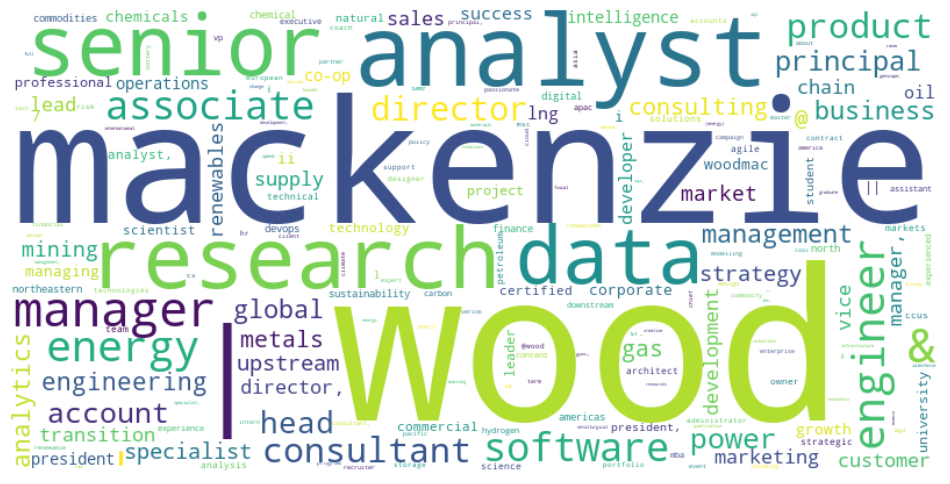

In [19]:
# PLOT A
import csv
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# define stopwords list
stopwords = ['at', 'and', 'in', 'of', 'the', 'to', 'a', 'with', 'for', 'as', 'on', 'is', 'an', 'be', 'or', 'will', 'are']

# read in the csv file
filename = 'people_headlines.csv'
with open(filename, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    headlines = [row['Headline'] for row in reader]

# concatenate all headlines into a single string
all_headlines = ' '.join(headlines)

# convert all words to lowercase
all_headlines = all_headlines.lower()

# split string into individual words
words = all_headlines.split()

# remove stopwords
words = [word for word in words if word not in stopwords]

# count word frequency and create a word cloud
word_freq = Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# plot the word cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [41]:
import pandas as pd

def generate_top_combinations(num_words = 2, top = 20):
    # Load the CSV file
    df = pd.read_csv('people_headlines.csv')
    # Define a list of characters to remove
    undesired_characters = ['@', '|', '&', '-', '/', ',', '"']

    # Convert all columns to lowercase and remove undesired characters
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    df = df.replace({r: '' for r in undesired_characters}, regex=True)

    # Split the headline by words and count their frequency
    headlines = ' '.join(df['Headline'].tolist()).split()
    word_counts = Counter(headlines)

    # create a list of words to remove
    words_to_remove = ['wood', 'mackenzie', 'at', '|', '&', '@','-','/','of', 'and', 'the']

    # Generate a list of n-word combinations and remove any that contain words to remove or single-letter words
    combinations = [' '.join(i) for i in zip(*[headlines[j:] for j in range(num_words)])]
    combinations_counts = Counter(combinations)
    for w in words_to_remove:
        for key in combinations_counts.copy():
            if w in key.split(' ') or any(len(word) == 1 for word in key.split(' ')):
                del combinations_counts[key]


    # Filter out combinations that cannot be found in any of the headlines
    filtered_combinations = []
    for combination, count in combinations_counts.items():
        if any(combination in headline for headline in df['Headline']):
            filtered_combinations.append((combination, count))

    # Get the top x most common n-word combinations
    top_combinations = sorted(filtered_combinations, key=lambda x: x[1], reverse=True)[:top]
    return top_combinations


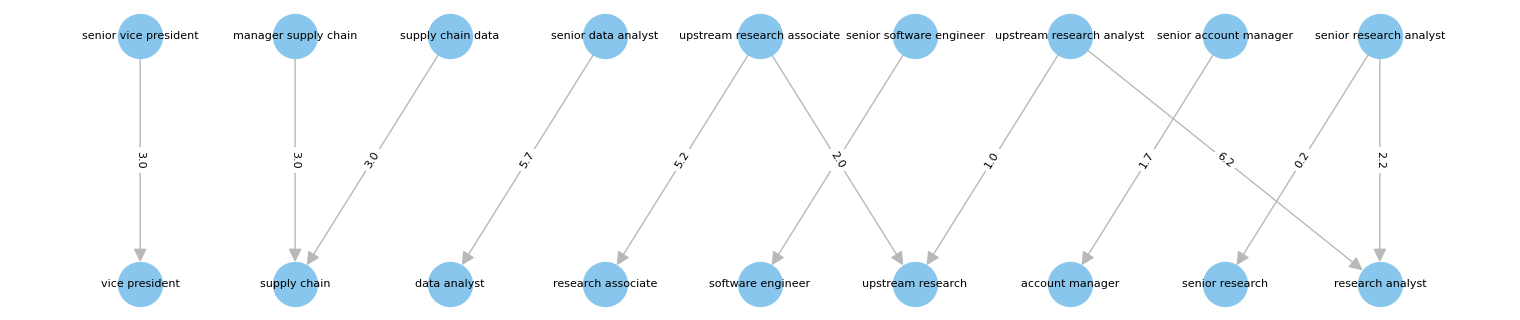

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

two_word_combinations = generate_top_combinations(2, 10)
three_word_combinations = generate_top_combinations(3, 10)

data = []
for three in three_word_combinations:
    for two in two_word_combinations:
        if three[0].find(two[0]) > -1:
            data.append([three, two])

# Create an empty graph
G = nx.DiGraph()

# Add nodes for the three-word phrases
for item in data:
    G.add_node(item[0][0], count=item[0][1], layer=2)
    G.add_node(item[1][0], count=item[1][1], layer=1)

# Add edges between the three-word phrases and their corresponding two-word phrases
for item in data:
    relation = round((item[1][1]- item[0][1])/item[0][1], 1)
    G.add_edge(item[0][0], item[1][0], weight=relation)

# Define the positions of the nodes in the tree graph
pos = nx.multipartite_layout(G, subset_key="layer", align="horizontal")

# Draw the tree graph
plt.figure(figsize=(15,3))
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000,
        node_color="#88c6ed", edge_color="#b8b8b8", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
plt.axis('off')
plt.show()


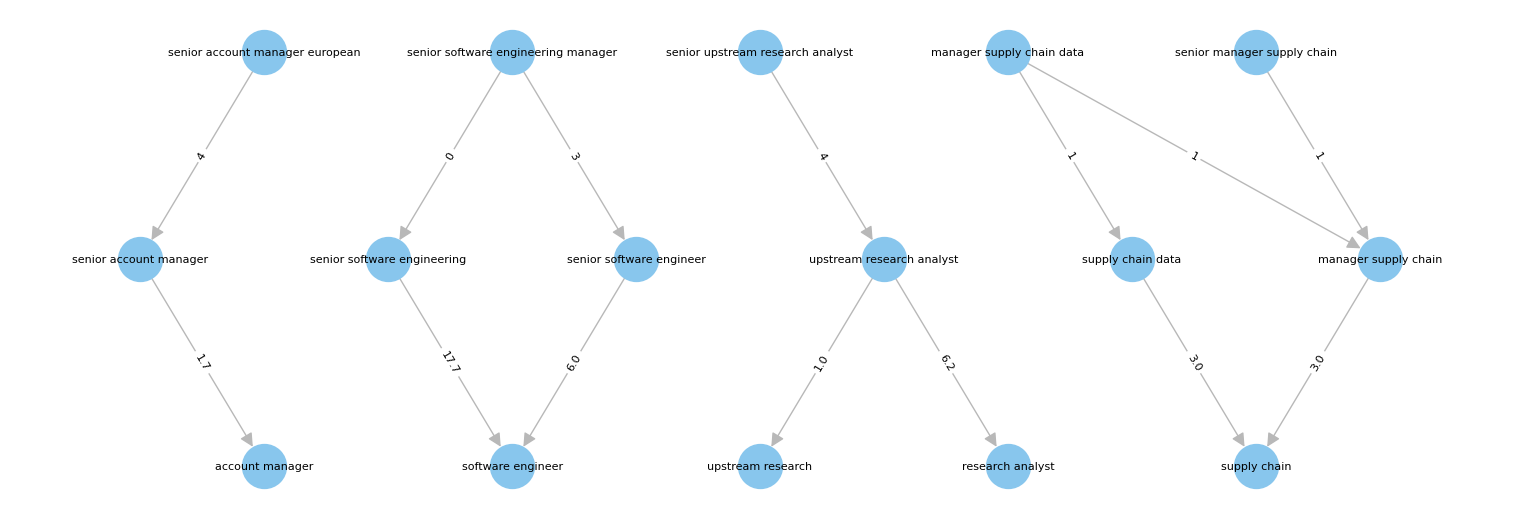

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

top = 20
two_word_combinations = generate_top_combinations(2, top)
three_word_combinations = generate_top_combinations(3, top)
four_word_combinations = generate_top_combinations(4, top)

data = []
for four in four_word_combinations:
    for three in three_word_combinations:
        for two in two_word_combinations:
            if (four[0].find(three[0]) > -1) and (three[0].find(two[0]) > -1):
                data.append([four, three, two])

# Create an empty graph
G = nx.DiGraph()

# Add nodes for the four-word phrases
for item in data:
    G.add_node(item[0][0], count=item[0][1], layer=3)
    G.add_node(item[1][0], count=item[1][1], layer=2)
    G.add_node(item[2][0], count=item[2][1], layer=1)

# Add edges between the four-word phrases and the three-word phrases they contain
for item in data:
    if item[0][0] in [i[0] for i in four_word_combinations]:  # Fixed the condition
        relation = round((item[1][1] - item[0][1])/item[0][1])
        G.add_edge(item[0][0], item[1][0], weight=relation)

# Add edges between the three-word phrases and their corresponding two-word phrases
for item in data:
    if item[1][0] in [i[0] for i in three_word_combinations]:  # Fixed the condition
        relation = round((item[2][1] - item[1][1])/item[1][1], 1)
        G.add_edge(item[1][0], item[2][0], weight=relation)

# Define the positions of the nodes in the tree graph
pos = nx.multipartite_layout(G, subset_key="layer", align="horizontal")

# Draw the tree graph
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1000,
        node_color="#88c6ed", edge_color="#b8b8b8", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
plt.axis('off')
plt.show()


In [23]:
import plotly.graph_objs as go

top_combinations = generate_top_combinations(2, 20)

# Create a bar chart of the top two-word combinations
fig = go.Figure(
    [go.Bar(x=[val[0]], y=[val[1]], hovertext=[f"Frequency: {val[1]}"], name="") for val in top_combinations]
)
fig.update_layout(
    title="Most Common X Combinations in Headlines",
    xaxis_title="Combination",
    yaxis_title="Frequency",
    xaxis_tickangle=-90
)
fig.show()
